### Libraries

In [33]:
import cv2 as cv
import time
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
from functions import * # own functions

### **(Memory and Color)** Load a photo into open CV and:
##### Change the green and blue channels.

Taking picture in 2 seconds...
Image saved at images/selfie.jpg


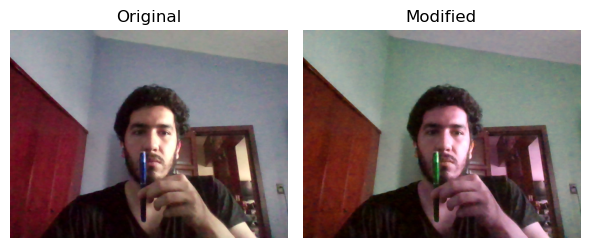

In [8]:
frame = take_pic(2,"images/selfie.jpg",False)
b,g,r = cv.split(frame)
mod_frame = cv.merge((g,b,r))

plot_img(2,(6,3),["Original", "Modified"],[frame, mod_frame])

##### Convert the original image into gray scale.


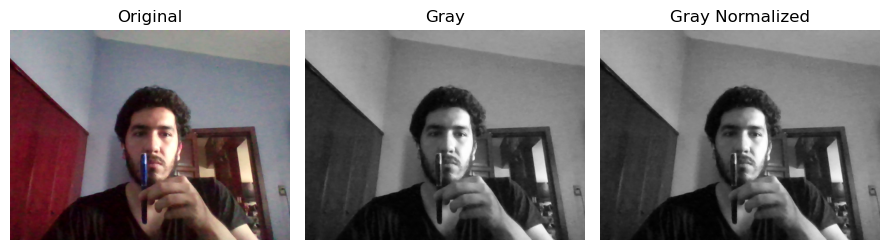

In [9]:
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
gray.astype(float)
grayN = cv.normalize(gray, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)

plot_img(3,(9,4.5),["Original", "Gray", "Gray Normalized"],[frame, gray, grayN])

##### Convert the original image into HSV.

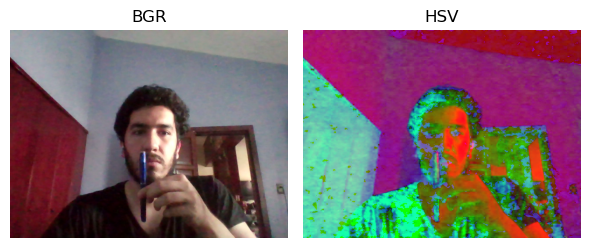

In [10]:
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
plot_img(2,(6,3),["BGR", "HSV"],[frame, hsv])

### **(Capture)** Use a video capture to:
Estimate the f number of your camera.

Use a reference object and measure at know distance, count the number of pixels to estimate the f number.

In [13]:
# The previous image of me holding a pen was taking 50 cm away from the object (pen), and the length of the 
# pen in the picture is 161 px, while the real length is 14.5 cm. Therefore we can calculate the focal length as:
F = (161 * 50) / 14
print(f"The focal length of my camera is {F}") 

The focal length of my camera is 575.0


#### Use the estimate f number to measure the distance to a second reference object.
Repeat the experiment at least using thee different distances. Report the measurement error.


In [15]:
### Now I will estimate the distance three times to another object (a notebook with 17.9 cm of height)
for i in range(3):
    _ = take_pic(2,f"images/notebook_{i+1}.jpg",False)
    time.sleep(15) # To give me time to measure a new distance

Taking picture in 2 seconds...
Image saved at images/notebook_1.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_2.jpg
Taking picture in 2 seconds...
Image saved at images/notebook_3.jpg


In [28]:
real_distances = [50, 70, 90] # in cm
px_distances = [187, 143, 110] # in px
estim_distances = [(17.9 * F) / x for x in px_distances]
perc_error = [(abs(real - estim) / real) * 100 for real, estim in zip(real_distances, estim_distances)]

print(f"The estimated distances in cm were: {', '.join([f'{dist:.2f}' for dist in estim_distances])} and the average percentage error was: {np.mean(perc_error):.2f}%")

The estimated distances in cm were: 55.04, 71.98, 93.57 and the average percentage error was: 5.62%


### **(Enhancing)** Use a reference image to:
Do histogram equalization.

Apply equalization independently to all channels.


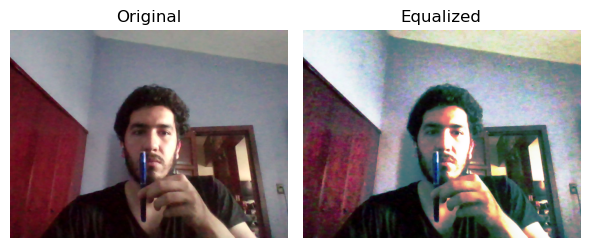

In [30]:
channels = b, g, r # from previous image of me holding a pen

eq_channels = [cv.equalizeHist(channel) for channel in channels]
eq_image = cv.merge(eq_channels)

plot_img(2,(6,3),["Original", "Equalized"],[frame, eq_image])

Apply equalization to the V channel on the HSV converted image. 

Once the V channel has been equalized convert back to RGB and display the image

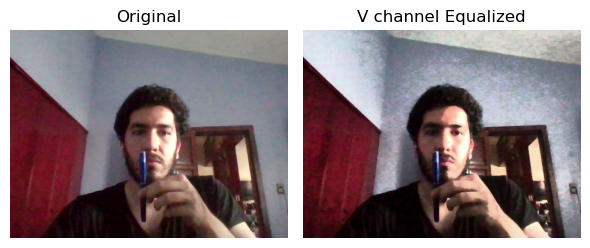

In [32]:
h,s,v = cv.split(hsv)
eq_v = cv.equalizeHist(v)
hsv_mod = cv.merge([h,s,eq_v])
brg_mod = cv.cvtColor(hsv_mod, cv.COLOR_HSV2BGR)

plot_img(2,(6,3),["Original", "V channel Equalized"],[frame, brg_mod])

Apply the gamma enhancing:

Enhance the low intensity areas.

Enhance the high intensity areas.

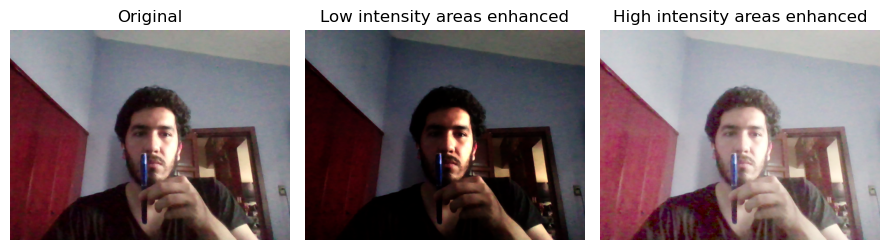

In [41]:
plot_img(3,(9,4.5),["Original", "Low intensity areas enhanced", "High intensity areas enhanced"],[frame, adjust_gamma(frame,0.5), adjust_gamma(frame,2)])

### **(Sampling)** Use your own image.
Do the pyramid representation:

Down sample the image to 2,4,8,16.
- Nearest neighbor


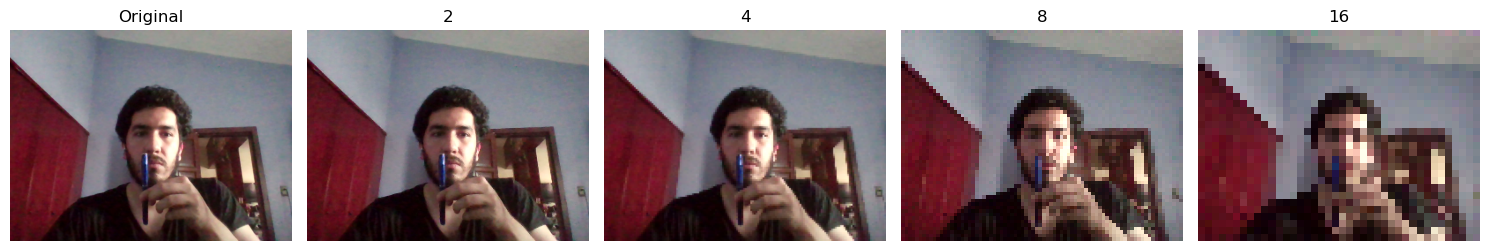

In [44]:
factors = [2, 4, 8, 16]

nn_imgs = []
for factor in factors:
    resample = cv.resize(frame, (frame.shape[1] // factor, frame.shape[0] // factor), interpolation=cv.INTER_NEAREST)
    nn_imgs.append(resample)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, nn_imgs[0], nn_imgs[1], nn_imgs[2], nn_imgs[3]])


- Bilinear filtering

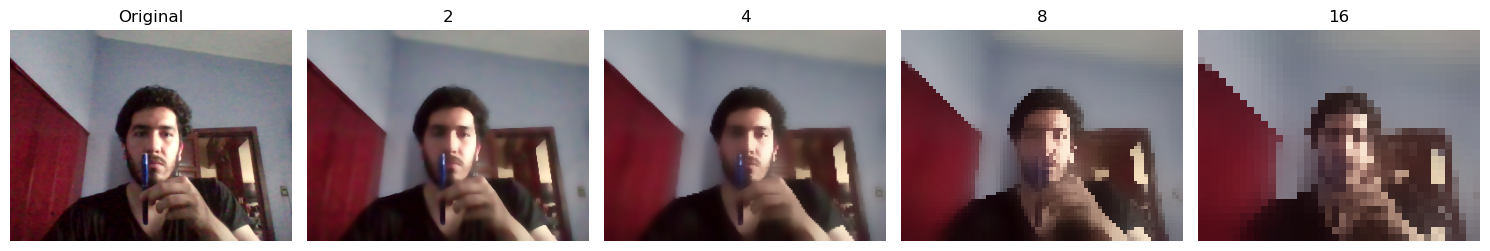

In [62]:
bf_imgs = []

for i, factor in enumerate(factors):
    resample = nn_imgs[i]
    filtered = cv.bilateralFilter(resample,9,120,120)
    bf_imgs.append(filtered)

plot_img(5,(15,7.5),["Original", "2", "4", "8", "16"],[frame, bf_imgs[0], bf_imgs[1], bf_imgs[2], bf_imgs[3]])

- Max pooling filtering

In [ ]:
frame = cv.imread("images/selfie.jpg")

        Use the 1/16 representation and up sample to the original size:
            Use bilinear interpolation.
            Use SINC interpolation.

### **(Filtering)** Use your own image:

    Add gaussian noise:
        Apply mean filter.
        Apply median filter.
        Apply anisotropic filter.
    Add salt and pepper noise:
        Apply mean filter.
        Apply median filter.
        Apply anisotropic filter.
    Apply the following filters:
        Laplacian
        Sobel x
        Laplacian of Gaussian
        Sharpening
    Investigate Homomorphic filter (https://en.wikipedia.org/wiki/Homomorphic_filtering 

    Links to an external site.)
        Implement using only convolutions.
        Implement it on the Fourier domain.
    Implement and test your own versions of the
        IIR filter
        FIR filter

### **(Edge Detection)** Use your own image.

    Compute the image gradient of the grayscale image.
        Show your result as an RGB
            Red channel the Gradient Magnitude
            Blue channel the gradient angle
            Green channel the gray scale image
    Using the zero-crossing property of the Laplacian:
        Show the localization of the edges of the previous image.
    Compute the Canny edges:
        Use at least three different values of sigma.
